In [67]:
!pip install pytickersymbols
!pip install pandas_datareader 


In [279]:
import numpy as np
import pandas as pd
import matplotlib_inline
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10, 6)
import scipy.optimize
from pandas_datareader import data as web
import yfinance as yf
# from pandas_datareader import data


Some helper functions

In [246]:
def port_mean(R,W):
    return np.sum(R*W)

def port_var(W,C):
    return np.dot(np.dot(W,C), W)

In [249]:
def optimize_weights(R,C,rf):
    # utility function which we have to optimize
    def util_function(W,R,C,rf):
        mean = port_mean(R,W)
        var = port_var(W,C)
        util = (mean - rf) / np.sqrt(var)
        return 1/util

    n = len(R)
    W = np.ones(n)/n # initialize weights with equal values
    bound = [(0.,1.) for i in range(n)]  #defining bounds for weights
    print("x")
    constraint = [{'type': 'eq', 'fun': lambda W: np.sum(W)-1.}] #constraint for weights
    print("y")

    optimized_weights = scipy.optimize.minimize(util_function, W, (R,C,rf), method='SLSQP', constraints=constraint, bounds=bound)
    if not optimized_weights.success: raise BaseException(optimized_weights.message)
    return optimized_weights.x


In [250]:
# for different returns we will find optimal weights and mean, variance 
# which will help in plotting graph
def optimize_frontier(R,C,rf):
    # utility function for a particular return 
    def util_function(W,R,C,r):
        mean = port_mean(R,W)
        var = port_var(W,C)
        penalty = 100 * abs(mean-r)
        return var + penalty

    frontier_means = []
    frontier_vars = []
    frontier_weights = []
    n = len(R)

    for r in np.linspace(min(R), max(R), num=30):
        W = np.ones(n)/n
        bound = [(0,1) for i in range(n)]  #defining bounds for weights
        constraint = [{'type': 'eq', 'fun': lambda W: np.sum(W)-1}] #constraint for weights

        optimize_weights = scipy.optimize.minimize(util_function, W, (R,C,r), method='SLSQP', bounds=bound, constraints=constraint)
        
        if not optimize_weights.success: raise BaseException(optimize_weights.message)

        frontier_weights.append(optimize_weights.x)
        frontier_means.append(r)
        frontier_vars.append(port_var(optimize_weights.x, C))

    return np.array(frontier_means), np.array(frontier_vars), np.array(frontier_weights)


Load Data

In [251]:
from pytickersymbols import PyTickerSymbols
stock_data = PyTickerSymbols()
stocks_list = stock_data.get_dow_jones_nyc_yahoo_tickers()
len(stocks_list)

31

In [252]:
tickers = yf.Tickers(stocks_list)
tickers.tickers['MSFT'].info['marketCap']


2309834932224

In [253]:
market_cap = {}
for str in stocks_list:
    market_cap[str] = tickers.tickers[str].info['marketCap']
# market_cap

In [254]:
# Function loads historical stock prices of nine major S&P companies and returns them together
# with their market capitalizations
def load_data():
    symbols = stocks_list
    n = len(symbols)
    prices_out, caps_out = [], []
    for s in symbols:
        dataframe = pd.read_csv('dow-jones/%s.csv' % s, index_col=None, parse_dates=['date'])
        prices = list(dataframe['close'])[-500:] # trailing window 500 days
        prices_out.append(prices)
        caps_out.append(market_cap[s])
    return symbols, prices_out, caps_out

names, prices, caps = load_data()
# print(prices)
prices = np.array(prices)

In [272]:
class Result:
    def __init__(self, W, tangent_mean, tangent_var, frontier_mean, frontier_var, frontier_weights):
        self.W=W
        self.tangent_mean=tangent_mean
        self.tangent_var=tangent_var
        self.frontier_mean=frontier_mean
        self.frontier_var=frontier_var
        self.frontier_weights=frontier_weights


In [256]:
# Function takes historical stock prices together with market capitalizations and
# calculates weights, historical returns and historical covariances
def historical_returns(prices):
    prices = np.matrix(prices)  # create numpy matrix from prices
    # create matrix of historical returns
    rows, cols = prices.shape
    print(rows, cols)
    returns = np.empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1
    # calculate returns
    expreturns = np.array([])
    for r in range(rows):
        # calculating expected return of portfolio by taking average of all returns in a day
        expreturns = np.append(expreturns, np.mean(returns[r]))
    # calculate covariances
    covars = np.cov(returns)
    expreturns = ((1 + expreturns) ** 250) - 1  # Annualize returns
    print(expreturns)
    covars = covars * 250  # Annualize covariances
    return expreturns, covars

W = np.array(caps) / sum(caps) # calculate market weights from capitalizations
R, C = historical_returns(prices)
rf = .035  # Risk-free rate


# p = np.array(C)

31 500
[-0.13630592  0.15947943  0.04383655  0.03061833  0.16005632  0.47213893
  0.0619381   0.14572275 -0.06602396  0.12586927  0.12788811  0.09936519
 -0.24383468  0.06314194  0.02672323  0.13278052 -0.04278376  0.20485078
  0.09307216  0.06315281  0.18989119  0.23422477 -0.16473307  0.02409753
  0.00815807 -0.05347986 -0.2672985   0.08266552  0.02869028 -0.15928005
 -0.03163634]


In [273]:
def get_frontier(R, C, rf):
    W = optimize_weights(R, C, rf)
    tangent_mean = port_mean(R, W)
    tangent_var = port_var(W, C)
    frontier_means, frontier_vars, frontier_weights = optimize_frontier(R, C, rf)
    return Result(W, tangent_mean, tangent_var, frontier_means, frontier_vars, frontier_weights)

In [274]:
result1 = get_frontier(R, C, rf)
n = len(R)

x
y


In [284]:
def display_assets(names, R, C, color='black'):
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color), plt.grid(True)  # draw assets
    for i in range(n): 
        plt.text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment='center', color=color) # draw labels

def display_frontier(result: Result, label=None, color='black'):
    from collections import defaultdict
    from IPython.core.display import HTML
    plt.text(result.tangent_var ** .5, result.tangent_mean, ' tangent', verticalalignment='center', color=color)
    plt.scatter(result.tangent_var ** .5, result.tangent_mean, marker='o', color=color), plt.grid(True)
    plt.plot(list(result.frontier_var ** .5), list(result.frontier_mean), label=label, color=color), plt.grid(True)  # draw efficient frontie

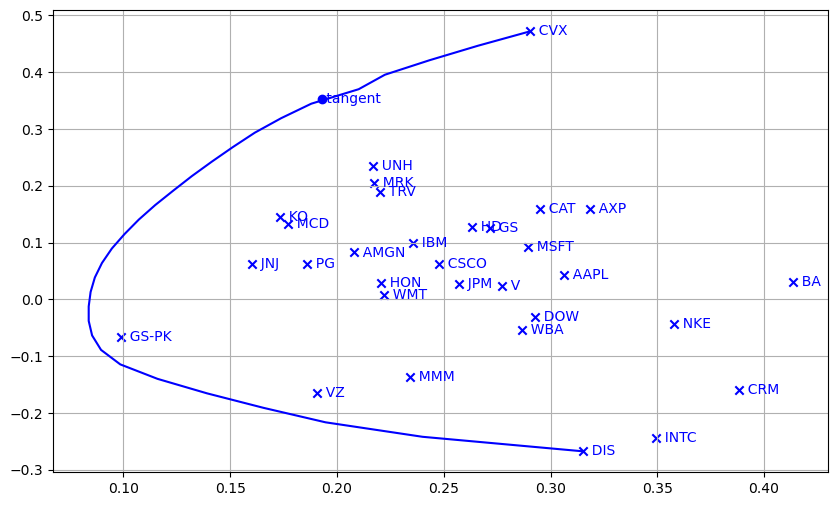

In [285]:
display_assets(names, R, C, color='blue')
display_frontier(result1, color='blue')

## Black-litterman reverse optimization

In [286]:
# Calculate portfolio historical return and variance
mean = port_mean(R, W)
var = port_var(W,C)

lmb = (mean - rf) / var  # Calculate risk aversion
Pi = np.dot(np.dot(lmb, C), W)  # Calculate equilibrium excess returns
print(Pi+rf, R)

[0.05602305 0.06985703 0.0836763  0.07243991 0.05791957 0.05327283
 0.06418132 0.05264494 0.04100944 0.06364666 0.06519522 0.05339575
 0.07525016 0.04704723 0.06111599 0.05289866 0.07595373 0.0453476
 0.08010261 0.05175543 0.0512764  0.05563844 0.04668027 0.06860277
 0.05148405 0.0594409  0.06948411 0.04919115 0.06023766 0.08196658
 0.05981578] [-0.13630592  0.15947943  0.04383655  0.03061833  0.16005632  0.47213893
  0.0619381   0.14572275 -0.06602396  0.12586927  0.12788811  0.09936519
 -0.24383468  0.06314194  0.02672323  0.13278052 -0.04278376  0.20485078
  0.09307216  0.06315281  0.18989119  0.23422477 -0.16473307  0.02409753
  0.00815807 -0.05347986 -0.2672985   0.08266552  0.02869028 -0.15928005
 -0.03163634]


x
y


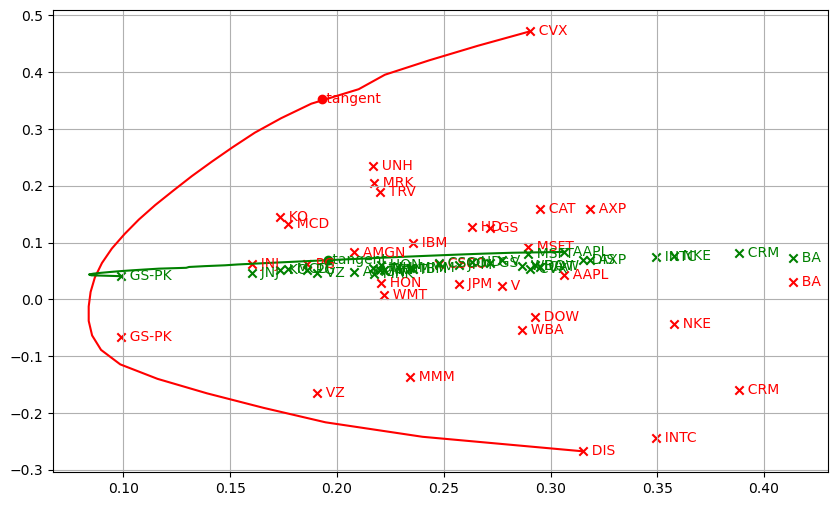

In [288]:
result2 = get_frontier(Pi+rf, C, rf)

display_assets(names, R, C, color='red')
display_frontier(result1, label='Historical returns', color='red')
display_assets(names, Pi+rf, C, color='green')
display_frontier(result2, label='Implied returns', color='green')